<h1>Building CNN from Scratch</h1>

In [1]:
import keras
import itertools
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
DROPOUT = 0.3
# image paths
train_path = '/Users/prabaniy/Desktop/potholes/training'
test_path = '/Users/prabaniy/Desktop/potholes/testing'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(32,32), classes=['potholes', 'not potholes'], batch_size=50)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(32,32), classes=['potholes', 'not potholes'], batch_size=50)


Found 1329 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [3]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

/Users/prabaniy/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


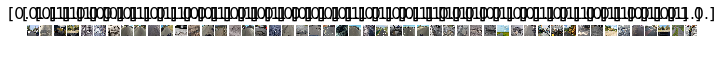

In [4]:
imgs , labels = next(train_batches)
plots(imgs, titles=labels)

In [5]:
# Building CNN, it good at capturing local parameters.
K.clear_session()
model = Sequential()
# the deeper we go into the network the richer and more unique are the patterns
# convolve the images with filters
model.add(Conv2D(32, kernel_size=(3,3),
                 padding='same', 
                 activation='relu',
                 input_shape=(32,32,3)))
model.add(Conv2D(32, (3,3), activation='relu'))
# pooling- reduces size of the image preserving the information about the feature location
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(64, (3,3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
# pooling- reduces size of the image preserving the information about the feature location
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT))

model.add(Flatten())
# Fully connected layer
model.add(Dense(128, activation='relu'))

model.add(Dropout(DROPOUT))
# output layer
model.add(Dense(2, activation='softmax'))

# Compiling simply creates an object that stores our model we have created
# here we can specify our loss function, optimizer and define our performance

model.compile(loss='categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [7]:
# steps_per_epoch: data per epoch 
data_augmentation = False
epochs = 1
steps_per_epoch = 50
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch,
                   validation_data=test_batches, validation_steps=steps_per_epoch,
                   epochs=epochs, verbose=2, shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.15,  # set range for random shear
        zoom_range=0.2,  # set range for random zoom
        channel_shift_range=10,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_batches)
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_batches, steps_per_epoch=steps_per_epoch),
                        epochs=epochs,
                        validation_data=test_batches, validation_steps=steps_per_epoch,
                        workers=4) 

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 123s - loss: 8.5458 - acc: 0.4693 - val_loss: 10.7282 - val_acc: 0.3344


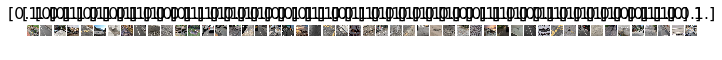

In [58]:
# Predecting

test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
#predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [59]:
test_labels = test_labels[:,0]
print(test_labels)

[0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0.]


In [60]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [61]:
# confustion matrix
cm = confusion_matrix(test_labels, predictions[:,0])

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [63]:
cm_plot_labels = ['potholes', 'not potholes']

Confusion matrix, without normalization
[[17  0]
 [33  0]]


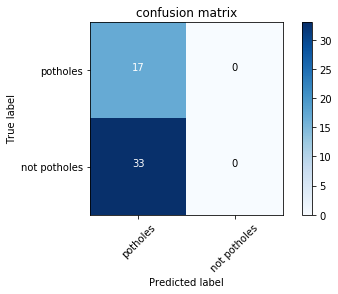

In [64]:
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

<h1> END of CNN</h1>

In [ ]:
model.save('my_model.h5')